#프로젝트 소개
CNN을 활용해 강아지 감정을 분류하고, YOLOv8을 활용해 강아지 탐지 성능을 최적화하여 실시간 감정 분석 시스템을 구현한 프로젝트

# 주요 기능

● 강아지의 감정 상태를 'Happy', 'Angry', 'Relaxed', 'Sad' 4가지 범주로 분류

● 데이터셋이 적으므로 Numpy 배열 형태로 데이터를 주입

● Epoch 150번 훈련 결과 Train accuracy - 99% Train Loss - 0.3% , Val accuracy - 99% Val Loss - 0.09% 달성

● YOLOv8을 사용하여 강아지만을 탐지 후 훈련한 CNN 모델에 입력하여 실시간으로 감정 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


지정된 디렉토리에서 이미지를 불러오고, 크기 조정(200 x 200) 및 RGB 변환 수행

클래스 이름을 기반으로 원핫 인코딩된 레이블을 생성하여 데이터셋 구성(총 이미지 3975장)

In [ ]:
import os
import cv2
import tensorflow as tf
image_path = '/content/drive/MyDrive/dog_emotion/Dog Emotion'
class_names = sorted(os.listdir(image_path))

import numpy as np
img_size = (200 , 200, 3)

images = []
labels = []

for class_name in class_names:
  images_files_folder_name = os.path.join(image_path , class_name)
  if os.path.isdir(images_files_folder_name):
    for image_name in os.listdir(images_files_folder_name):
      if image_name.endswith('.jpg'):
        image_full_path = os.path.join(images_files_folder_name , image_name)
        img = cv2.imread(image_full_path)
        img_resize = cv2.resize(img , img_size[:2])
        img_cvt = cv2.cvtColor(img_resize , cv2.COLOR_BGR2RGB)
        images.append(img_cvt)

        #레이블 원핫 인코딩 해주기
        label = np.zeros(len(class_names))
        label[class_names.index(class_name)] = 1
        #print(label)
        labels.append(label)

print(f"Total images : {len(images)} , Total labels : {len(labels)}")

Total images : 3975 , Total labels : 3975


클래스 이름 확인

In [ ]:
class_names

['angry', 'happy', 'relaxed', 'sad']

이미지와 레이블 리스트를 넘파이 형태로 변환

In [ ]:
images = np.asarray(images)
labels = np.asarray(labels)

images , labels 리스트를 X_train 과 X_val로 분할(Train에 80%, Validation에 20% 할당)

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

넘파이 배열 형태로 모델에 데이터를 주입

150번의 Epoch 후 Train accuracy 99% Train Loss 0.3% Valid accuracy 99% Valid Loss 0.09% 도달

레이블을 원핫인코딩 하였으므로 Categorical_Crossentropy 사용

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = img_size),
    tf.keras.layers.Rescaling(scale = 1. / 255),
    tf.keras.layers.Conv2D(64 , kernel_size = 3 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64 , kernel_size = 3 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(128 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(256 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(512 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(512 , kernel_size = 2 , activation = 'relu' , padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names) , activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 20)
history = model.fit(images , labels , epochs = 150 , validation_data = (X_val , y_val) , callbacks = [early_stopping_cb])

Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 481ms/step - accuracy: 0.2522 - loss: 7.3194 - val_accuracy: 0.2503 - val_loss: 1.3865
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - accuracy: 0.2772 - loss: 1.3862 - val_accuracy: 0.2503 - val_loss: 1.3871
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.2937 - loss: 1.3485 - val_accuracy: 0.2403 - val_loss: 1.3868
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - accuracy: 0.3301 - loss: 1.2993 - val_accuracy: 0.3132 - val_loss: 1.3466
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.3433 - loss: 1.2654 - val_accuracy: 0.3648 - val_loss: 1.2869
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 0.3564 - loss: 1.2567 - val_accuracy: 0.3409 - val_loss: 1.2553
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 0.3395 - loss: 1.2768 - val_accuracy: 0.3849 - val_loss: 1.2206
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - accuracy: 0.3574 -

Matplotlib을 사용하여 Train , Valid의 Accuracy 및 Loss 시각화

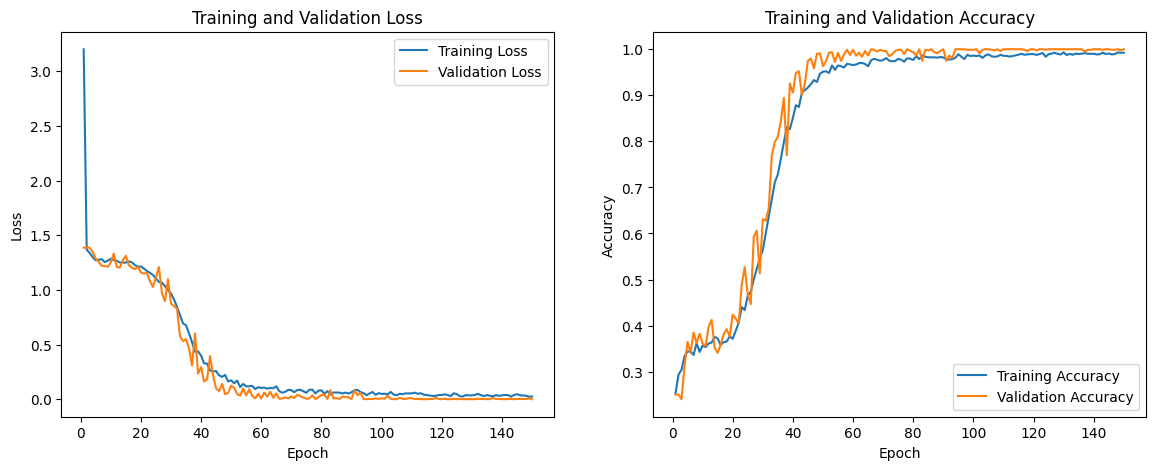

In [ ]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs = range(1 , len(loss) + 1)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, accuracy, label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Matplotlib를 사용하여 Confusion Matrix (혼동 행렬) 시각화

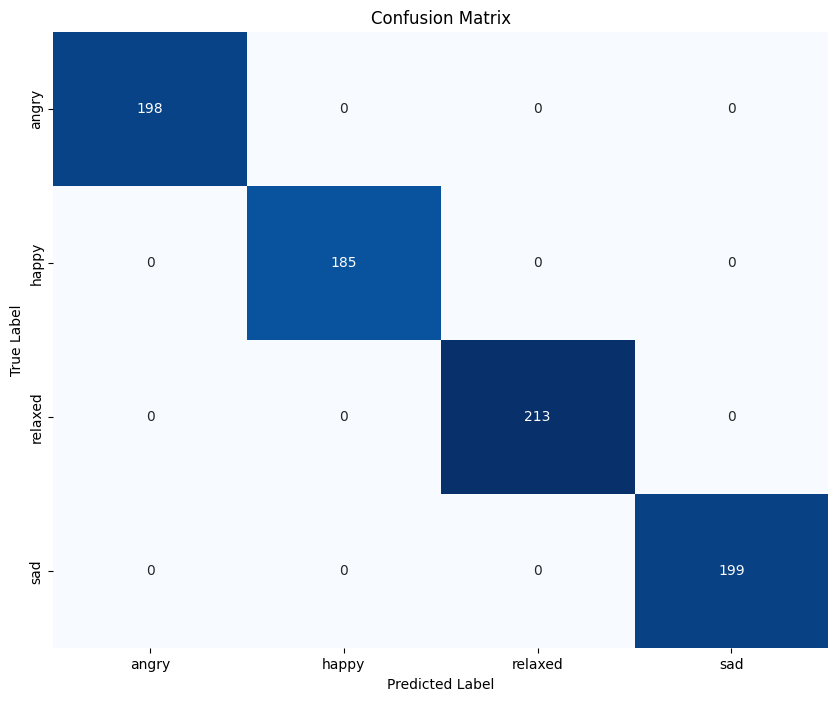

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis = 1)
y_true = y_val.argmax(axis = 1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


검증 데이터에서 샘플 이미지를 시각화하고, 실제 레이블과 예측 레이블 비교

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


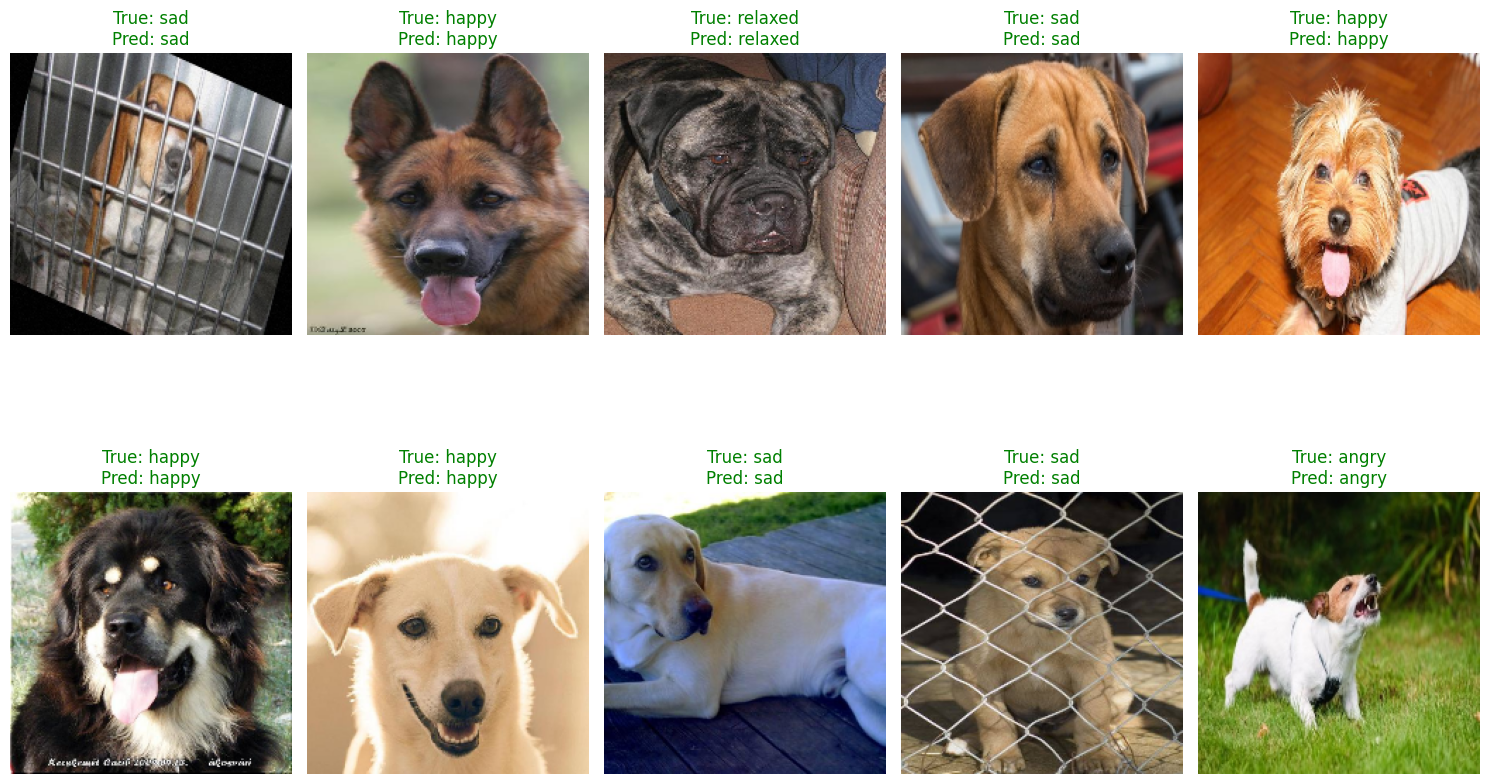

In [ ]:
import random
import matplotlib.pyplot as plt

random_sample = random.sample(range(X_val.shape[0]), 10)
sample_images = X_val[random_sample]
sample_labels = y_val[random_sample]
predictions = model.predict(sample_images)
predicted_labels = predictions.argmax(axis=1)
true_labels = sample_labels.argmax(axis=1)

plt.figure(figsize = (15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')

    true_label_name = class_names[true_labels[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", color="green" if true_label_name == predicted_label_name else "red")
plt.tight_layout()
plt.show()


외부 이미지(Train 및 Val 데이터셋에 없는 이미지)를 가져와 예측 후 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


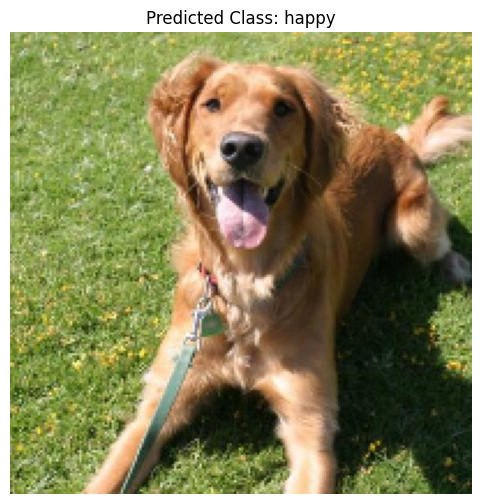

[[3.8081351e-05 9.9999641e+01 1.9073281e-04 1.2985207e-04]]
['angry', 'happy', 'relaxed', 'sad']


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

test_image_path = '/content/drive/MyDrive/dog_emotionn/images/happy/1219229004_1132301808_b.jpg'

def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지 파일 오류!")
    img_resized = cv2.resize(img, target_size[:2])
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array = np.asarray(img_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

target_size = (200, 200)
test_img_array = load_and_preprocess_image(test_image_path, target_size)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

class_names = sorted(os.listdir(image_path))
predicted_class_name = class_names[predicted_class]

plt.figure(figsize = (6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()
print(predictions * 100)
print(class_names)

YOLOv8을 사용하여 실시간 강아지 감정분석(강아지 영상이 담긴 동영상으로 실시간 강아지 탐지 진행)

In [ ]:
import cv2
from ultralytics import YOLO
import tensorflow as tf
import numpy as np

#사전 훈련된 YOLO 모델을 사용
detection_model = YOLO('yolov8s.pt')
prediction_model = tf.keras.models.load_model('/content/drive/MyDrive/final_dog_emotion.keras')

cap = cv2.VideoCapture('/content/drive/MyDrive/happy_dog.mp4') #강아지 영상이 담긴 동영상으로 실시간 강아지 탐지 진행

while cap.isOpened():

    ret , frame = cap.read()

    if not ret:
        break

    results = detection_model.predict(frame , conf = 0.3)

#강아지만을 인식하기 위한 작업
    dog_class_id = 16
    dog_boxes = []
    filtered_results = []
    for result in results:
        for box in result.boxes:
            if box.cls == dog_class_id:
                dog_boxes.append(box)
    if dog_boxes:
        for box in dog_boxes:
            x1 , y1 , x2 , y2 = map(int , box.xyxy[0])
            crop = frame[y1 : y2 , x1 : x2]
            resized_crop = cv2.resize(crop , (200 , 200))
            data = np.expand_dims(resized_crop , axis = 0)
            prediction = prediction_model.predict(data)
            prediction_argmax = np.argmax(prediction)
            emotion_label = ['Angry' , 'Happy' , 'Relaxed' , 'Sad']
            emotion = emotion_label[prediction_argmax]

            cv2.putText(frame , emotion , (x1 + 15 , y1 + 25) , cv2.FONT_HERSHEY_COMPLEX , 0.9, (255, 0, 0), 2)
            cv2.rectangle(frame , (x1 , y1) , (x2 , y2) , (0 , 255 , 0) , 2)
    cv2.imshow('video' , frame)


    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()